# Clustering Methods
During this experiment, we will implement clustering methods from scratch using Pytorch.<br>
The [Mall Customer Segmentation Data](https://www.kaggle.com/vjchoudhary7/customer-segmentation-tutorial-in-python/discussion/82190) will be used the clustering.

In [252]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

### Read csv using Pandas

In [229]:
customers = pd.read_csv(os.path.join('data', 'Mall_Customers.csv'))

In [251]:
customers.head(5)

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,1,19,15,39
1,2,1,21,15,81
2,3,0,20,16,6
3,4,0,23,16,77
4,5,0,31,17,40


### Transform string to categorical

In [230]:
le = LabelEncoder()
customers['Gender'] = le.fit_transform(customers['Gender'])

In [231]:
for cl, lbl in zip(le.classes_, le.transform(le.classes_)):
    print(cl, ':', lbl)

Female : 0
Male : 1


In [232]:
# Convert to Pytorch tensor
X = torch.from_numpy(customers.values).float()

### Implementation of Principal Component Analysis
In this section, we will use PCA to reduce the number of feature to two, in order to visualize the data in 2D.

In [233]:
# Covariance function
# cov(X) = (X - E[X])T (X - E[X])
def cov(A):
    A -= A.mean(dim=0, keepdim=True)
    fact = 1.0 / (A.shape[0] - 1)
    cov = fact * A.T.mm(A)
    return cov

# PCA function
def pca(A, target_dim=2):
    cov_a = cov(A)
    
    # Get the left singular vector of the covariance
    _, _, V = torch.svd(cov_a)

    # Get the first kth singular vector of the covariance
    transform_mat = V[:, :target_dim]

    # Multiply the data by the transform matrix to get the reduced data
    A_reduce = A.mm(transform_mat)
    return A_reduce, transform_mat

In [234]:
X_pca = pca(X)[0]

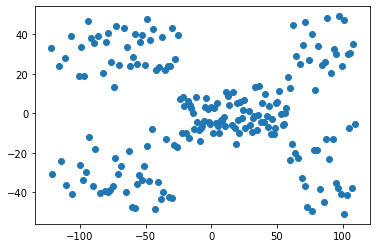

In [235]:
plt.scatter(X_pca[:, 0], X_pca[:, 1])

Our goal is to separate the data into groups where the samples in each group are similar.

### Standardize the data
The K-means method is a distance based approach for clustering.<br>
It is mandatory to standardize the data to prevent the features with higher values to contribute more than the others.

In [247]:
X_s = StandardScaler().fit_transform(X_pca)
X_s = torch.from_numpy(X_s)

### K-Means Clustering
K-means algorithm is an iterative approach that tries to partition a dataset into $K$ predefined clusters where each data point belongs to only one cluster.
            
This algorithm works that way:
- specify number of clusters $K$
- randomly initialize one centroid in space for each cluster
- for each point, compute the euclidean distance between the point and each centroid and assign the point to the closest centroid
- change the centroid value based on the points present in each cluster and repeat the previous step until the centroid does not change anymore

The approach, K-means follows to solve this problem is called Expectation-Maximization. The E-step assign each point to a cluster, and the M-step refines the value of centroid based on the points inside each cluster.

More formally, the objective function to minimize is as follows:<br>
$$
    J = \sum_{i=1}^{m} \sum_{k=1}^{K} \mathbb{I}(z_i = k)||x_i - \mu_k||_2^2
$$<br>
where $z_i$ is the cluster assigned to $x_i$ and $\mu_k$ is the mean of the cluster $k$.

The E-step is defined as:<br>
$$
    z_i^{*} = \text{argmin}_{k} ||x_i - \mu_k||_2^2
$$<br>

And the M-step is defined as:<br>
$$
    \mu_k = \frac{1}{\sum_{i=1}^m \mathbb{I}(z_i = k)} \sum_{i=1}^m  x_i\mathbb{I}(z_i = k)
$$<br>

In practice, we should run multiple K-means with different initialization of the centroids and keep the parameters that min
Since K-means is a distance based algorithm, is it mandatory to standardize the data. 

In [248]:
class KMeansClustering():
    def __init__(self, n_clusters=5):
        # Number of clusters
        self.n_clusters = n_clusters
        self.centroids = None
        
    
    def fit_transform(self, X, n_iter=20):
        size = X.shape[0]
        # Find min and max values to generate a random centroid in this range
        xmax = X.max(dim=0)[0].unsqueeze(1)
        xmin = X.min(dim=0)[0].unsqueeze(1)
        
        dists = torch.zeros((size, self.n_clusters))
        best_loss = 1e10
        pred = None
        # Repeat n number of time`
        for _ in range(n_iter):
            # Initialize n centroids
            centroids = (xmin - xmax) * torch.rand((X.shape[1], self.n_clusters)) + xmax
            old_loss = -1
            while 1:
                # E-step: assign each point to a cluster
                for i in range(self.n_clusters):
                    ctr = centroids[:, i].unsqueeze(1)
                    dists[:, i] = (X - ctr.T).pow(2).sum(dim=1).sqrt()
                dists_min, labels = dists.min(dim=1)
                
                # M-step: re-compute the centroids based on the new labeled data
                for i in range(self.n_clusters):
                    idx = torch.where(labels == i)[0]
                    if len(idx) == 0:
                        continue
                    centroids[:, i] = X[idx].mean(dim=0)
                    
                # Loss is the sum of the distance of the points respectively to their centroid
                new_loss = dists_min.sum()
                if old_loss == new_loss:
                    break
                old_loss = new_loss
            if new_loss < best_loss:
                best_loss = new_loss
                pred = labels
        # Return the best prediction based on the objective function
        return pred

In [249]:
kms = KMeansClustering(n_clusters=5)
pred = kms.fit_transform(X_s)

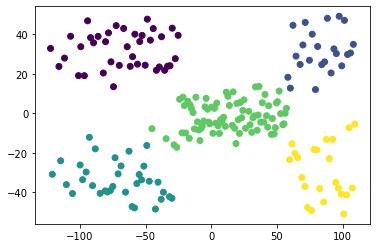

In [250]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=pred)